# Unsupervised Machine Learning II: Additional Applications of Clustering Analyses

This training module was developed by Alexis Payton, MS, Lauren E. Koval, and Dr. Julia E. Rager

Spring 2024

## Introduction to Training Module
ADD WORDS ABOUT DIFFERENCES BETWEEN THIS MODULE AND THE PREVIOUS ONE 
exploring additional applications of the unsupervised machine learning technique of clustering. 

## *K*-Means Clustering
In simple terms, *k*-means clustering is an unsupervised machine learning technique that partitions similiar objects or data points into clusters. The algorithm seeks to minimize the sum of squares or total sqauared Euclidean distance between each object and their cluster mean. 

### Deriving the Optimal Number of *K*-Means Clusters
Typically there are three methods to find the *k* or number of clusters for *k*-means: the **elbow method**, **silhouette method**, and the **gap statistic method**. These techniques find the optimal *k* using visual inspection.

+ **Elbow Method**: uses a plot of the within cluster sum of squares (WCSS) on the y axis and different values of *k* on the x axis. The location where WCSS is the *minimized* or where an "elbow" can be seen is the optimal *k* value. After, a certain point having more clusters doesn't lead to a significant reduction in WCSS. 

In [ ]:
# INSERT FIGURE expectation vs. reality based on these: https://builtin.com/data-science/elbow-method
# knitr::include_graphics("Module5_5_Images/Module5_5_Image1.png")

Looking at the figures above, the elbow point is much clearer in the first plot versus the second, however typically elbow curves typically resemble the second figure. That's why it's recommended to use all three methods to determine the optimal number of clusters. 

+ **Silhouette Method**: uses a plot of the average silhouette width (score) on the y axis and different values of *k* on the x axis. The silhouette score is measure of each object's similarity to its own cluster and how disimiliar it is to other clusters. The location where the average silhouette width is *maximized* is the optimal *k* value.

SHOULD I INCLUDE A FIGURE HERE TOO??

+ **Gap Statistic Method**: uses a plot of the gap statistic on the y axis and different values of *k* on the x axis. The gap statistic is measure of the intracluster variation for different values of *k*, therefore the location where this metric is *maximized* is the optimal *k* value. This method can actually be used for both *k*-means and hierarchical clustering.
  
SHOULD I INCLUDE A FIGURE HERE TOO??

For additional information and code on all three methods, check out [Determining the Optimal Number of Clusters: 3 Must Know Methods](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/).

<br>

## Hierarchical Clustering
**Hierarchical clustering** groups objects into clusters that can then be visually represented in a dendogram. The hiearchical clustering dendogram below depicts is based on the "USArrests" dataset available in R. ???

In [ ]:
# knitr::include_graphics("Module5_5_Images/Module5_5_Image2.png")

Methods include clustering based on ...

+ **Complete Linkage**: the maximum distance between two data points located in separate clusters. 
+ **Single Linkage**: the minimum distance between two data points located in separate clusters. 
+ **Average Linkage**: the average distance pairwise distance between all pairs of data points in separate clusters.
+ **Centroid Linkage**: the distance between the centroids or centers of each cluster.
+ **Ward Linkage**: seeks to minimize the variance between clusters.  

Each method has its advtanages and disadvantages and more information on all distance calculations between clusters can be found at [Hierarchical Clustering](https://www.learndatasci.com/glossary/hierarchical-clustering/#Hierarchicalclusteringtypes).

We will apply these techniques using an example dataset from a previously published study where cytokine concentrations were derived from 44 subjects with varying smoking statuses (14 non-smokers, 17 e-cigarette users, and 13 cigarette smokers) from 4 different regions in the body. These methods are further described in the publication below:

+ Payton AD, Perryman AN, Hoffman JR, Avula V, Wells H, Robinette C, Alexis NE, Jaspers I, Rager JE, Rebuli ME. Cytokine signature clusters as a tool to compare changes associated with tobacco product use in upper and lower airway samples. American Journal of Physiology-Lung Cellular and Molecular Physiology 2022 322:5, L722-L736. PMID: [35318855](https://journals.physiology.org/doi/abs/10.1152/ajplung.00299.2021)

Let's read in and view the dataset we'll be working with.

### Installing required R packagesIf you already have these packages installed, you can skip this step, or you can run the below code which checks installation status for you

In [34]:
if (!requireNamespace("vegan"))
  install.packages("vegan");
if (!requireNamespace("ggrepel"))
  install.packages("ggrepel");
if (!requireNamespace("dendextend"))
  install.packages("dendextend");
if (!requireNamespace("ggsci"))
  install.packages("ggsci");
if (!requireNamespace("FactoMineR"))
install.packages("FactoMineR");

Loading required namespace: dendextend

Registered S3 method overwritten by 'dendextend':
  method     from 
  rev.hclust vegan



### Loading required R packages

In [1]:
library(readxl)
library(factoextra)
library(FactoMineR)
library(tidyverse)
library(vegan)
library(ggrepel)
library(reshape2)
library(pheatmap)
library(ggsci)
suppressPackageStartupMessages(library(dendextend))

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




### Set your working directory

In [2]:
# ```{r, eval=FALSE, echo=TRUE}
# setwd("/filepath to where your input files are")
# ```

### Importing example dataset

Then let's read in our example dataset. As mentioned in the introduction, this example dataset contains cytokine concentrations derived from 44 subjects. Let's upload and view these data:

In [2]:
# Reading in files
cytokines_df = data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))

# Viewing data 
head(cytokines_df)

,Original_Identifier,Group,SubjectNo,SubjectID,Compartment,Protein,Conc,Conc_pslog2
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,E_C_F_002,NS,1,NS_1,NELF,IFNg,17.642316,4.220509
2,E_C_F_002,NS,1,NS_1,NELF,IL10,2.873724,1.953721
3,E_C_F_002,NS,1,NS_1,NELF,IL12p70,1.625272,1.392467
4,E_C_F_002,NS,1,NS_1,NELF,IL13,36.117692,5.214035
5,E_C_F_002,NS,1,NS_1,NELF,IL1b,104.409217,6.719857
6,E_C_F_002,NS,1,NS_1,NELF,IL6,21.159536,4.469856


These data contain the following information:
+ `Original_Identifier`: initial identifier given to each subject by our wet bench colleagues
+ `Group`: denotes the smoking status of the subject ("NS" = "non-smoker", "Ecig" = "E-cigarette user", "CS" = "cigarette smoker")
+ `SubjectNo`: ordinal subject number assigned to each subject after the dataset was wrangled (1-44)
+ `SubjectID`: unique subject identifier that combines the group and subject number
+ `Compartment`: region of the body from which the sample was taken ("NLF" = "nasal lavage fluid sample", "NELF" = "nasal epithelieum lining fluid sample", "Sputum" = "induced sputum sample", "Serum" = "blood serum sample")
+ `Protein`: cytokine
+ `Conc`: concentration (pg/mL)
+ `Conc_pslog2`: psuedo-log~2~ concentration

Now that the data has been read in, we can start by asking some initial questions about the data.

## Training Module's Environmental Health QuestionsThis training module was specifically developed to answer the following environmental health questions:1. What are the optimal number of ***k*-means** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers?
2. After selecting a cluster number, which cytokines were assigned to each *k*-means cluster?
3. What are the optimal number of **hierarchical** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers? How do the hierarchical cluster assignments compare to the *k*-means cluster assignments?4. How can we visualize these cytokine clusters? SHOULD I MAKE THIS QUESTION BETTER
5. What cytokines have the greatest contributions to the first eigenvector????

To answer the first envirionmental health question, let's start by filtering to include only NELF derived samples and non-smokers.

In [3]:
baseline_df = cytokines_df %>%
    filter(Group == "NS", Compartment == "NELF") 

head(baseline_df)

,Original_Identifier,Group,SubjectNo,SubjectID,Compartment,Protein,Conc,Conc_pslog2
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,E_C_F_002,NS,1,NS_1,NELF,IFNg,17.642316,4.220509
2,E_C_F_002,NS,1,NS_1,NELF,IL10,2.873724,1.953721
3,E_C_F_002,NS,1,NS_1,NELF,IL12p70,1.625272,1.392467
4,E_C_F_002,NS,1,NS_1,NELF,IL13,36.117692,5.214035
5,E_C_F_002,NS,1,NS_1,NELF,IL1b,104.409217,6.719857
6,E_C_F_002,NS,1,NS_1,NELF,IL6,21.159536,4.469856


The functions we require us to cast the data wider, which we will do using the `dcast()` function from the *reshape2* package. 

In [4]:
wider_baseline_df = reshape2::dcast(baseline_df, SubjectID ~ Protein, value.var = "Conc_pslog2") %>% 
  column_to_rownames("SubjectID")

head(wider_baseline_df)

,Eotaxin,Eotaxin3,Fractalkine,I309,IFNg,IL10,IL12p70,IL13,IL17B,IL17D,⋯,IL6,IL8,IP10,ITAC,MCP1,MIG,MIP1a,MIP1b,TARC,TNFa
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NS_1,7.215729,4.396783,13.58455,0.000000,4.220509,1.953721,1.3924669,5.214035,5.670001,5.7285643,⋯,4.469856,14.85407,12.670258,11.211643,8.943624,14.365531,5.236115,6.869259,4.972066,3.903196
NS_10,8.016193,4.006488,13.67988,0.000000,1.990018,1.145162,2.0678450,3.878793,5.793669,2.2508408,⋯,3.300551,14.72563,11.806168,3.640216,8.157660,9.774213,6.009427,7.363432,4.893786,2.627590
NS_11,6.264252,5.289509,12.95222,0.000000,2.656691,1.348623,2.2078380,4.130891,4.858181,0.7247419,⋯,3.183762,15.49819,12.204282,3.684703,8.038883,9.366035,6.016487,6.272712,3.558072,3.009646
NS_12,6.938344,3.597945,13.46465,0.000000,3.439682,1.801954,2.1397923,5.313787,0.000000,0.0000000,⋯,4.478494,14.99239,11.169441,4.035557,7.101491,9.111526,5.925305,6.583509,4.385354,4.354130
NS_13,5.152683,3.051951,12.11074,0.000000,2.318340,1.176498,0.7194139,4.034806,5.179790,3.6580199,⋯,4.158730,12.98480,9.809327,6.155755,7.834706,11.631858,3.664734,4.705741,3.713002,2.716356
NS_14,7.937892,3.063025,12.78566,1.617372,3.439850,1.800412,1.2381746,4.804240,5.612285,7.2668665,⋯,4.676109,13.60216,12.825214,9.784703,6.857290,14.722907,6.202924,6.817265,4.171323,3.597219


Derving clusters using the `fviz_nbclust()` function to determine the optimal *k* based on suggestions from the elbow, silouette, and gap statistic methods. 

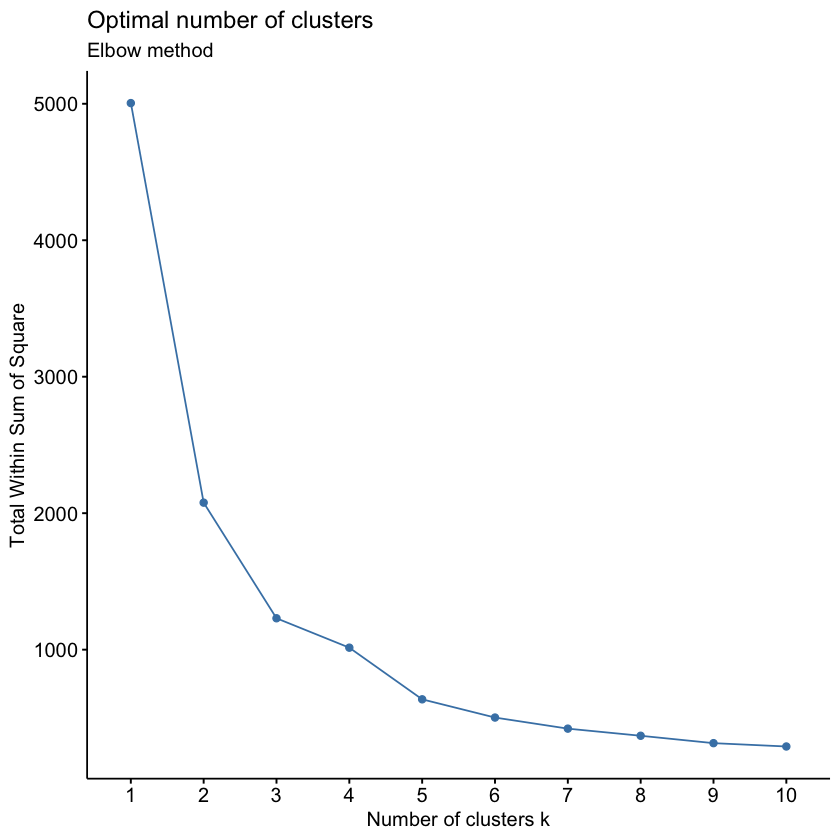

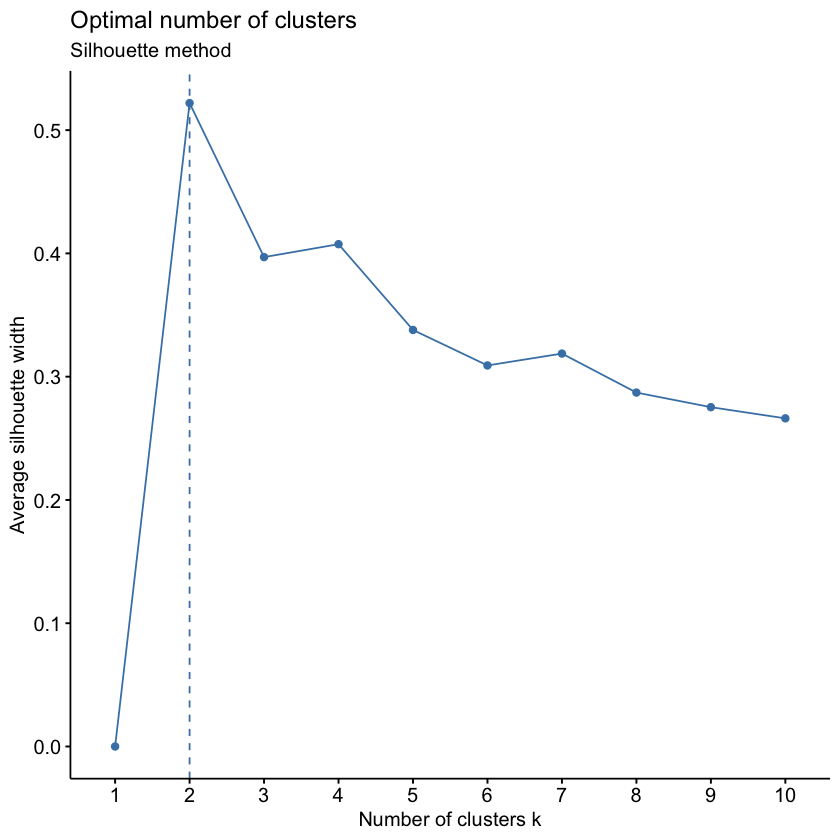

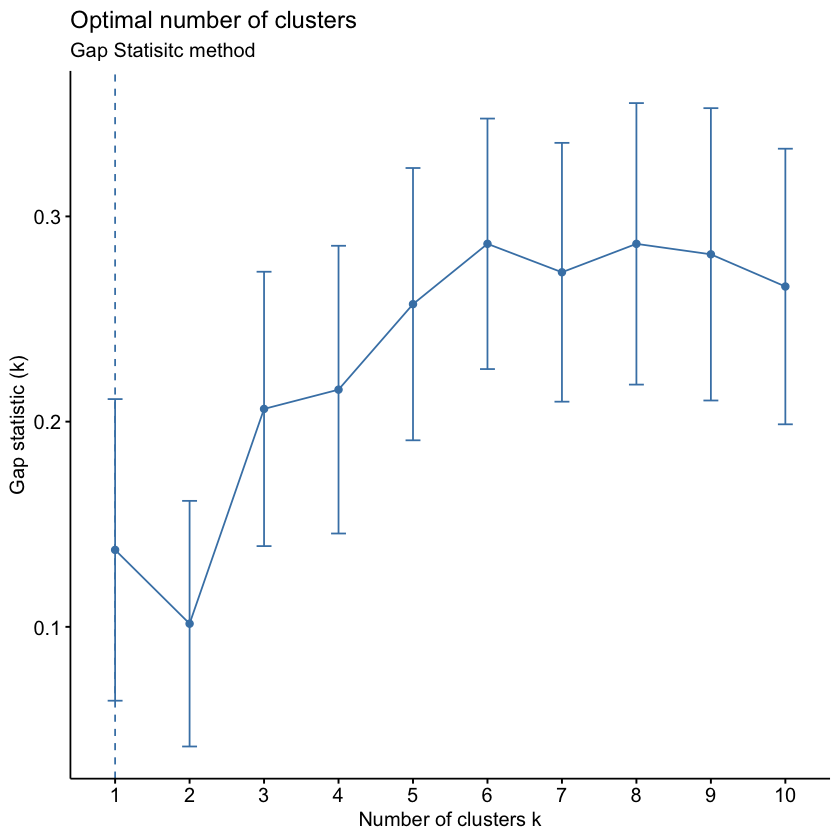

In [6]:
# Transposing the dataframe first
t_wider_baseline_df = t(wider_baseline_df)

# Elbow method
fviz_nbclust(t_wider_baseline_df, kmeans, method = "wss") +
  labs(subtitle = "Elbow method") 

# Silhouette method
fviz_nbclust(t_wider_baseline_df, kmeans, method = "silhouette") + 
  labs(subtitle = "Silhouette method") 

# Gap statistic method
fviz_nbclust(t_wider_baseline_df, kmeans, method = "gap_stat") + 
  labs(subtitle = "Gap Statisitc method") 

The elbow method is suggesting 2 or 3 clusters, the silhouette method is suggesting 2, and the gap statistic method suggests 1. Since each of these methods is recommeding differ *k* values, we can go ahead and run *k*-means to visualize the clusters and test those different *k*'s. *K*-means clusters will be visualized using the `fviz_cluster()` function.

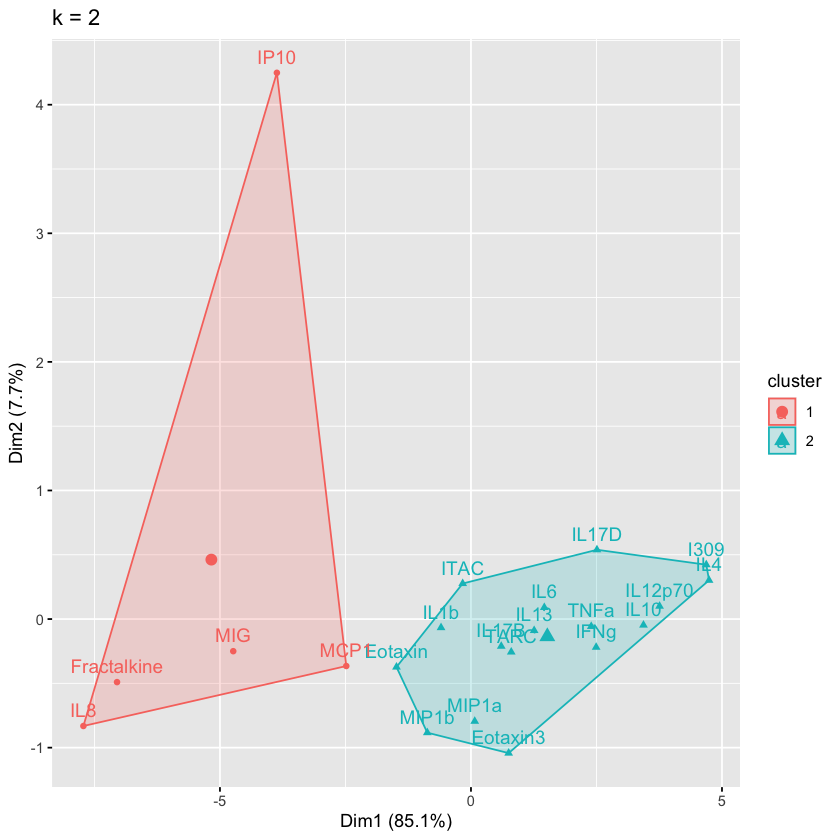

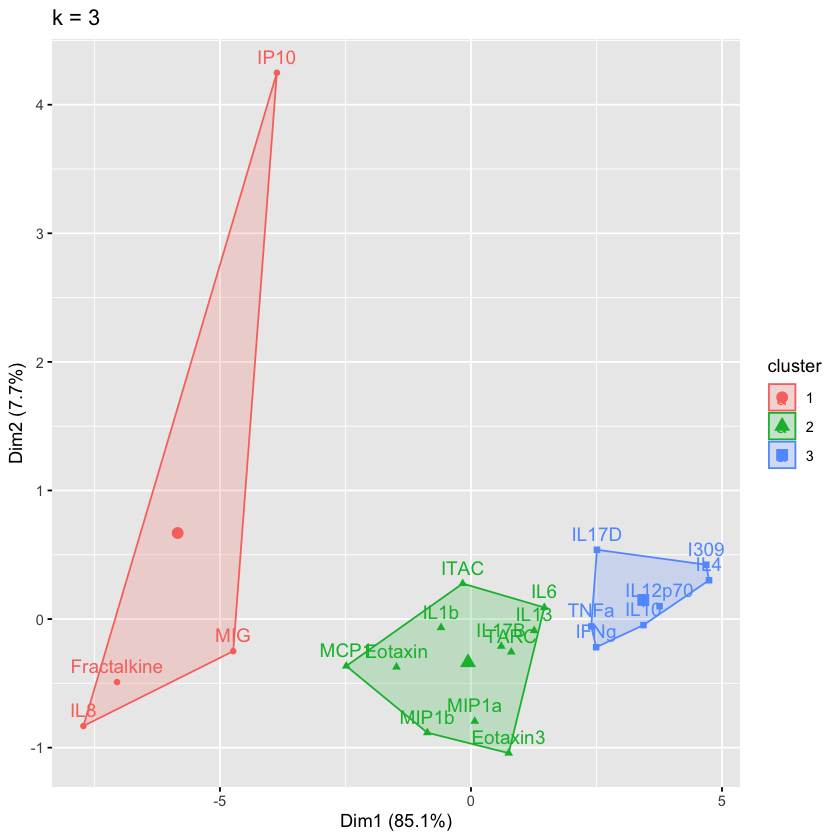

In [8]:
# Choosing to iterate through 2 or 3 clusters using i as our iterator
for (i in 2:3){
    # nstart = number of random starting partitions, it's recommended for nstart > 1
    cluster_k <- kmeans(t_wider_baseline_df, centers = i, nstart = 25)
    cluster_plot <- fviz_cluster(cluster_k, data = t_wider_baseline_df) + ggtitle(paste0("k = ", i))
    print(cluster_plot)
}

### Answer to Environmental Health Question 1

*With this, we can answer **Environmental Health Question #1***: What are the optimal number of ***k*-means** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers?

**Answer**: 2 or 3 clusters can be justified here, based on using the elbow or silhouette method or if *k*-means happens to group cytokines together that were implicated in similar biological pathways. In the final paper, we moved forward with 3 clusters, because that was still justifiable from the methods and we needed a bit more granularity in the clusters. 

The final cluster assignment can easily be obtained using the `kmeans()` function. 

In [7]:
cluster_kmeans_3 <- kmeans(t_wider_baseline_df, centers = 3, nstart = 25)
cluster_kmeans_df <- data.frame(cluster_kmeans_3$cluster) %>%
    # Reordering the dataframe so that the cytokines are arranged by their cluster assignment
    arrange(cluster_kmeans_3.cluster)
colnames(cluster_kmeans_df)[1] <- "K-Means Cluster"

cluster_kmeans_df

,K-Means Cluster
,<int>
Eotaxin,1
Eotaxin3,1
IL13,1
IL17B,1
IL1b,1
IL6,1
ITAC,1
MCP1,1
MIP1a,1


### Answer to Environmental Health Question 2

*With this, we can answer **Environmental Health Question #2***: After selecting a cluster number, which cytokines were assigned to each *k*-means cluster?

**Answer**: After choosing the number of clusters to be 3, *k* = 3, the cluster assignments are as follows: 

In [8]:
knitr::include_graphics("Module5_5_Images/Module5_5_Image3.png")

[1] "Module5_5_Images/Module5_5_Image3.png"
attr(,"class")
[1] "knit_image_paths" "knit_asis"       

<br>

## Hierarchical Clustering

Next, we'll turn our attention to answering environmental health question 3: What are the optimal number of **hierarchical** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers? How do the hierarchical cluster assignments compare to the *k*-means cluster assignments?

We'll start by using the `dist()`function to calculate the euclidean distance between the clusters followed by the `hclust()` function to obtain the hierarchical clustering assignments.

In [9]:
# Viewing the transposed dataframe we'll be working with
head(t_wider_baseline_df)

,NS_1,NS_10,NS_11,NS_12,NS_13,NS_14,NS_2,NS_3,NS_4,NS_5,NS_6,NS_7,NS_8,NS_9
Eotaxin,7.215729,8.016193,6.264252,6.938344,5.152683,7.937892,9.773407,6.12290913,5.758602,4.19868540,6.832578,7.998467,9.242464,7.127746
Eotaxin3,4.396783,4.006488,5.289509,3.597945,3.051951,3.063025,9.022390,2.50161364,2.721195,2.21084320,3.820379,5.549164,13.724108,3.553097
Fractalkine,13.584554,13.679882,12.952220,13.464652,12.110742,12.785656,14.961872,12.71538464,12.057105,10.38711624,12.917180,14.636190,14.047382,13.146599
I309,0.000000,0.000000,0.000000,0.000000,0.000000,1.617372,1.103140,0.00000000,0.000000,0.00000000,0.000000,0.000000,0.000000,0.000000
IFNg,4.220509,1.990018,2.656691,3.439682,2.318340,3.439850,4.394705,0.00000000,2.638213,0.04830196,1.914092,3.251501,4.104820,2.940248
IL10,1.953721,1.145162,1.348623,1.801954,1.176498,1.800412,2.652120,0.08945805,2.020155,0.84649523,1.119272,2.007941,2.576814,1.970627


In [10]:
# First scaling data with each subject (down columns)
scaled_df = data.frame(apply(t_wider_baseline_df, 2, scale))
rownames(scaled_df) = rownames(t_wider_baseline_df)

head(scaled_df)

,NS_1,NS_10,NS_11,NS_12,NS_13,NS_14,NS_2,NS_3,NS_4,NS_5,NS_6,NS_7,NS_8,NS_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Eotaxin,0.1563938,0.5913460,0.20280481,0.3812918,0.04218372,0.3889166,0.5142129,0.5748344,0.3352251,0.1297382,0.6605088,0.4509596,0.5504372,0.6258899
Eotaxin3,-0.4836295,-0.3751558,-0.03031899,-0.4135856,-0.51644074,-0.7745030,0.3434700,-0.3390521,-0.4516462,-0.3710044,-0.1481961,-0.1213017,1.4999690,-0.3063521
Fractalkine,1.6023933,1.9565250,1.80232784,1.9342844,1.89246390,1.5458678,1.6938060,2.2385415,1.9669167,1.6886200,2.2940816,2.0018134,1.5684615,2.1955622
I309,-1.4818900,-1.3408820,-1.29538062,-1.2697485,-1.32801259,-1.1195175,-1.4569648,-0.9703707,-1.1565995,-0.9279215,-1.1738781,-1.4178220,-1.4077759,-1.2329735
IFNg,-0.5236512,-0.8612069,-0.65999509,-0.4512458,-0.71152186,-0.6845711,-0.7086302,-0.9703707,-0.4731435,-0.9157541,-0.6599894,-0.6581332,-0.5380823,-0.4661787
IL10,-1.0383105,-1.0648515,-0.97283813,-0.8409577,-1.01515934,-1.0758338,-1.1048056,-0.9477947,-0.6332576,-0.7146872,-0.8733797,-0.9486817,-0.8618228,-0.7190487


Stuff about the `dist()` function. The `hclust()` is used to obtain BLAH BLAH and clusters using the complete method by default. The method can be changed in the function using the `method` parameter.  

In [11]:
# Calculating euclidean dist
dist_matrix <- dist(scaled_df, method = 'euclidean')

# Getting clusters???
cytokines_hc = hclust(dist_matrix)

cytokines_hc


Call:
hclust(d = dist_matrix)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 22 


Similar to what we did above using the elbow and siloheutte methods, dendograms will be visualized to determine the optimal number of hierarchical clusters using the `as.dendogram()` function. https://agroninfotech.blogspot.com/2020/06/visualizing-clusters-in-r-hierarchical.html

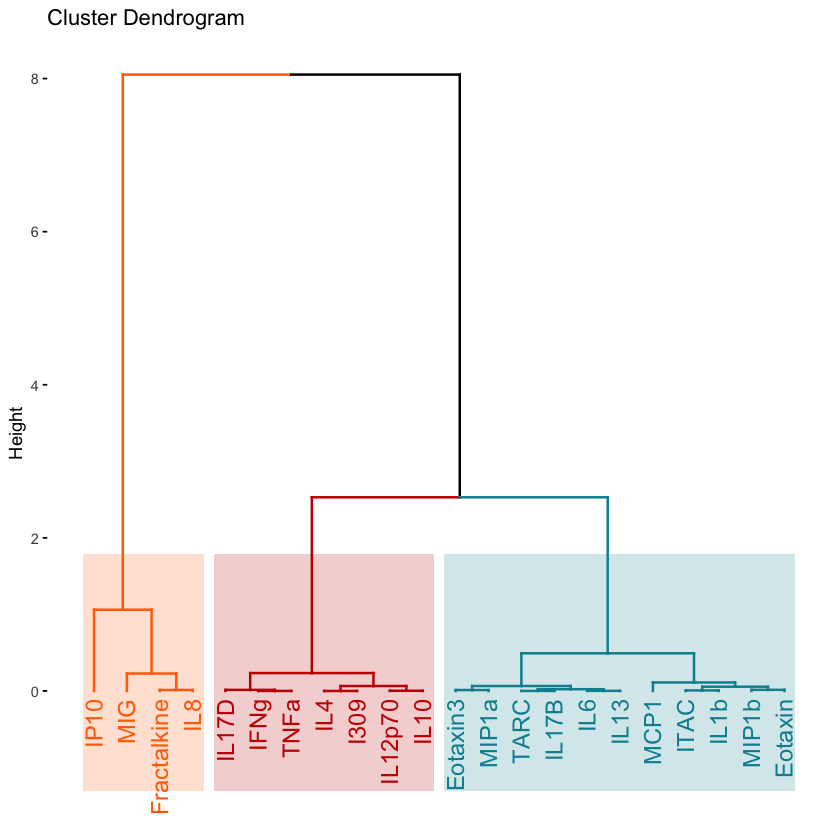

In [17]:
# Compute PCA with ncp = 2
# ADD WORDS/ USE A DIFFERENT COLOR PALETTE
# http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/117-hcpc-hierarchical-clustering-on-principal-components-essentials/

res.pca <- PCA(t_wider_baseline_df, ncp = 2, graph = FALSE)
# Compute hierarchical clustering on principal components
res.hcpc <- HCPC(res.pca, graph = FALSE)
fviz_dend(res.hcpc, 
          cex = 1, # Label size
          palette = "futurama", # Color palette see ?ggpubr::ggpar
          rect = TRUE, rect_fill = TRUE, # Add rectangle around groups
          rect_border = "futurama",  # Rectangle color
          labels_track_height = 0.8      # Augment the room for labels
         )

Similar to the results from the elbow and silohuette methods, the dendogram is suggesting 3 clusters. Let's move forward with 3 clusters and extract those cluster assignments using the `cutree()` function.

In [13]:
# Cuts the tree based upon the number of clusters specified by k
hc_assignments_df <- data.frame(cutree(cytokines_hc, k = 3)) %>%
    # Reordering the dataframe so that the cytokines are arranged by their cluster assignment
    arrange(cutree.cytokines_hc..k...3.)
colnames(hc_assignments_df) = "Hierarchical Cluster"

# Combining the dataframes to compare the cluster assignments from each approach
cbind(cluster_kmeans_df, hc_assignments_df)

,K-Means Cluster,Hierarchical Cluster
,<int>,<int>
Eotaxin,1,1
Eotaxin3,1,1
IL13,1,1
IL17B,1,1
IL1b,1,1
IL6,1,1
ITAC,1,1
MCP1,1,1
MIP1a,1,1


### Answer to Environmental Health Question 3

*With this, we can answer **Environmental Health Question #3***: What are the optimal number of **hierarchical** clusters the cytokines can be grouped into that were derived from nasal epithelium fluid in non-smokers? How do the hierarchical cluster assignments compare to the *k*-means cluster assignments?

**Answer**: 2 or 3 clusters can be justified here, but for the same reasons mentioned for the first environmental health question we landed on 3 clusters. *K*-means and hiearchical clustering yielded the same cytokine cluster assignments. 

<br>

## *K*-Means Cluster Visualization

One way to visualize clustering is to...WORDS ABOUT THIS. This was done above using the `fviz_cluster()` function.

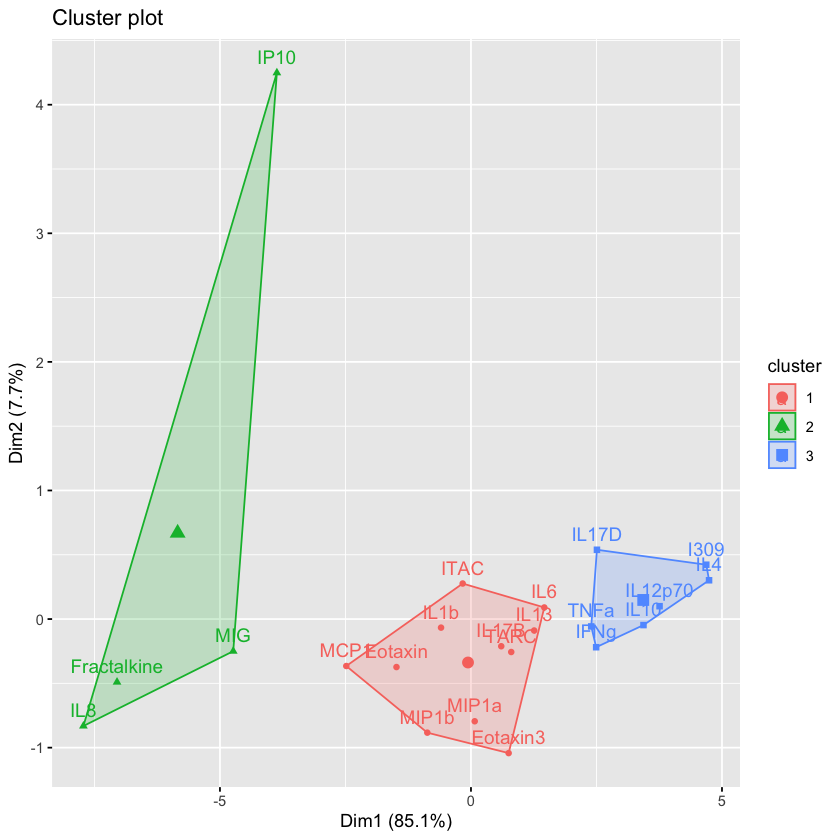

In [14]:
fviz_cluster(cluster_kmeans_3, data = t_wider_baseline_df)

Rather than using the `fviz_cluster()` function, we'll extract the data to build the sampe figure using `ggplot()`. For the manuscript this was necessary, since I needed to facet the plots for each compartment (ie. NLF, NELF, sputum, and serum). For a single plot, this data extraction isn't required and the figure above can be further customized within the `fviz_cluster()` function. However, we'll go through the steps of obtaining the indicies to recreate the same polygons in `ggplot()` directly. 

EXPLAIN WHAT'S HAPPENING BELOW..but I thought k-means doesn't use PCA?? https://www.datanovia.com/en/lessons/k-means-clustering-in-r-algorith-and-practical-examples/#computing-k-means-clustering

In [23]:
# First running PCA????
pca_cytokine <- prcomp(t_wider_baseline_df, scale = TRUE, center = TRUE)
# Only need PC1 and PC2 for plotting, so selecting the first two columns
baseline_scores_df <- data.frame(scores(pca_cytokine)[,1:2]) 
baseline_scores_df$Cluster <- cluster_kmeans_3$cluster
baseline_scores_df$Protein <- rownames(baseline_scores_df)

# Changing cluster to a character for plotting
baseline_scores_df$Cluster = as.character(baseline_scores_df$Cluster)

head(baseline_scores_df)

,PC1,PC2,Cluster,Protein
,<dbl>,<dbl>,<chr>,<chr>
Eotaxin,-1.4837936,0.37325290,1,Eotaxin
Eotaxin3,0.7505718,1.04251406,1,Eotaxin3
Fractalkine,-7.0500961,0.49034208,2,Fractalkine
I309,4.6869896,-0.42263944,3,I309
IFNg,2.4935464,0.21910385,3,IFNg
IL10,3.4361668,0.04689913,3,IL10


Within each cluster, the `chull()` function is used to compute the indicies of the points on the convex hull. These are needed for `ggplot()` to create the polygon shapes of each cluster. 

In [16]:
cluster_1 <- baseline_scores_df[baseline_scores_df$Cluster == 1, ][chull(baseline_scores_df %>% 
                                                                    filter(Cluster == 1)),]  # hull values for cluster 1
cluster_2 <- baseline_scores_df[baseline_scores_df$Cluster == 2, ][chull(baseline_scores_df %>% 
                                                                    filter(Cluster == 2)),]  # hull values for cluster 2
cluster_3 <- baseline_scores_df[baseline_scores_df$Cluster == 3, ][chull(baseline_scores_df %>% 
                                                                    filter(Cluster == 3)),]  # hull values for cluster 3
all_hulls_baseline <- rbind(cluster_1, cluster_2, cluster_3)
# Changing cluster to a character for plotting
all_hulls_baseline$Cluster = as.character(all_hulls_baseline$Cluster)

head(all_hulls_baseline)

,PC1,PC2,Cluster,Protein
,<dbl>,<dbl>,<chr>,<chr>
Eotaxin3,0.7505718,-1.04251406,1,Eotaxin3
MIP1b,-0.8699488,-0.88345324,1,MIP1b
MCP1,-2.4837364,-0.36522346,1,MCP1
ITAC,-0.1650598,0.27636151,1,ITAC
IL6,1.4605494,0.09012234,1,IL6
MIG,-4.7353654,-0.24986620,2,MIG


words CHANGE COLORS!!

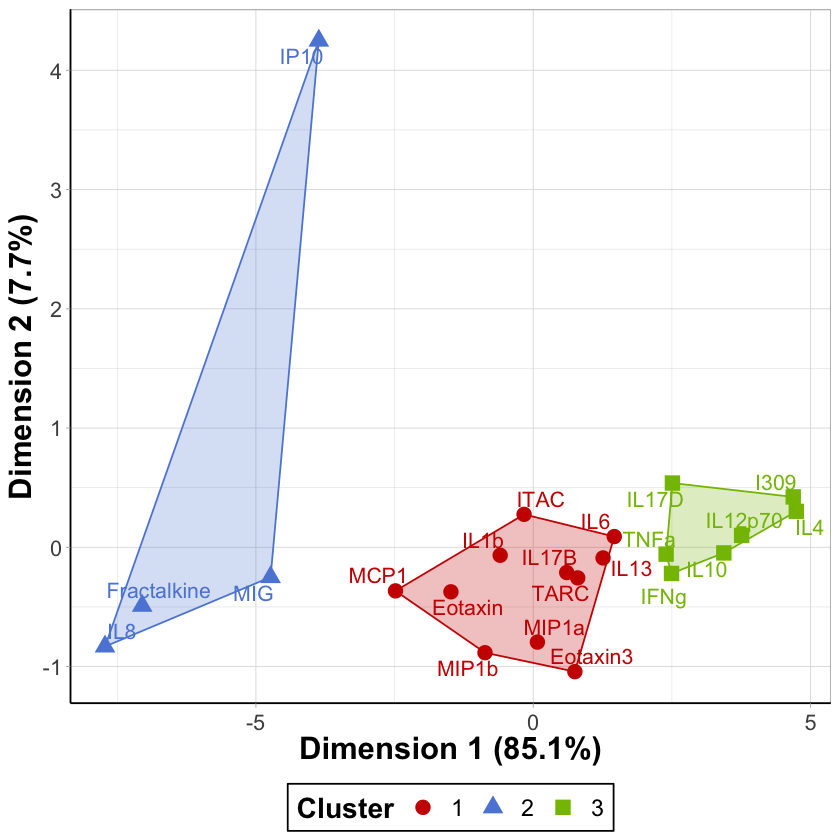

In [17]:
ggplot() + 
  geom_point(data = baseline_scores_df, aes(x = PC1, y = PC2, color = Cluster, shape = Cluster), size = 4) + 
  # Adding cytokine names
  geom_text_repel(data = baseline_scores_df, aes(x = PC1, y = PC2, color = Cluster, label = Protein), 
                  show.legend = FALSE, size = 4.5) + 
  # Creating polygon shapes of the clusters
  geom_polygon(data = all_hulls_baseline, aes(x = PC1, y = PC2, group = as.factor(Cluster), fill = Cluster, 
                                        color = Cluster), alpha = 0.25, show.legend = FALSE) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom', # moving the legend to the bottom
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'), #changes the legend background
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1 (85.1%)') + ylab('Dimension 2 (7.7%)') + #changing axis labels 

  # Using colors from the startrek palette from ggsci
  scale_color_startrek(name = 'Cluster') +
  scale_fill_startrek(name = 'Cluster') 

Notice that by doing so, we can specify the cluster assignments which we couldn't do with fviz???

## Hierarchical Clustering Visualization

In [18]:
# Ordering the subjects from greatest to least average cytokine concentration
ordered_subject_df = baseline_df %>%
    group_by(SubjectID) %>%
    summarize(avg_subject_conc = mean(Conc_pslog2)) %>%
    arrange(-avg_subject_conc)

head(ordered_subject_df)

SubjectID,avg_subject_conc
<chr>,<dbl>
NS_2,7.511631
NS_8,6.644485
NS_1,6.526902
NS_14,6.308285
NS_7,6.068341
NS_10,5.562889


In [19]:
ordered_subjects = ordered_subject_df$SubjectID

# Reordering the transposed wider dataframe
t_wider_baseline_df = t_wider_baseline_df[,ordered_subjects]
head(t_wider_baseline_df)

,NS_2,NS_8,NS_1,NS_14,NS_7,NS_10,NS_11,NS_12,NS_13,NS_9,NS_4,NS_6,NS_3,NS_5
Eotaxin,9.773407,9.242464,7.215729,7.937892,7.998467,8.016193,6.264252,6.938344,5.152683,7.127746,5.758602,6.832578,6.12290913,4.19868540
Eotaxin3,9.022390,13.724108,4.396783,3.063025,5.549164,4.006488,5.289509,3.597945,3.051951,3.553097,2.721195,3.820379,2.50161364,2.21084320
Fractalkine,14.961872,14.047382,13.584554,12.785656,14.636190,13.679882,12.952220,13.464652,12.110742,13.146599,12.057105,12.917180,12.71538464,10.38711624
I309,1.103140,0.000000,0.000000,1.617372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000000,0.00000000
IFNg,4.394705,4.104820,4.220509,3.439850,3.251501,1.990018,2.656691,3.439682,2.318340,2.940248,2.638213,1.914092,0.00000000,0.04830196
IL10,2.652120,2.576814,1.953721,1.800412,2.007941,1.145162,1.348623,1.801954,1.176498,1.970627,2.020155,1.119272,0.08945805,0.84649523


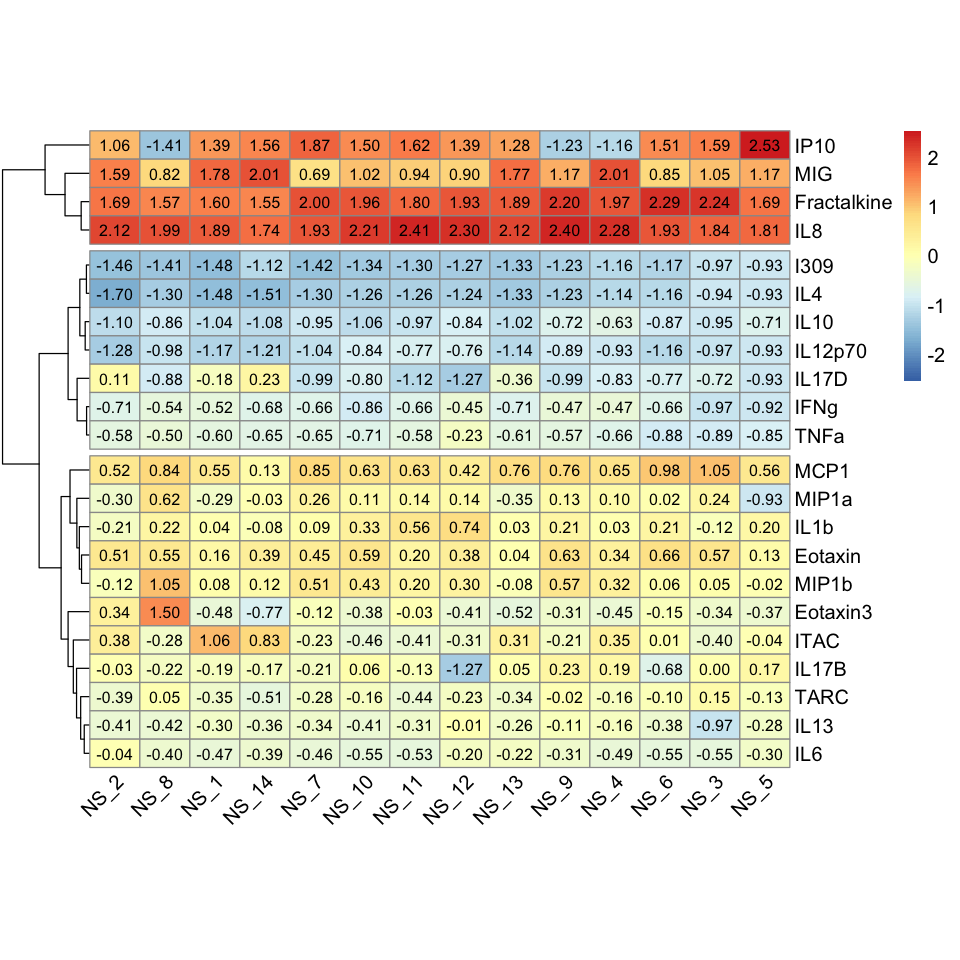

In [20]:
options(repr.plot.width=8, repr.plot.height=8) #changing size
pheatmap(t_wider_baseline_df, 
            cluster_cols = FALSE, # hierarchical clustering of cytokines
            scale = "column",    # scaling the data to make differences across cytokines more apparent
            cutree_row = 3, # adds a break bewtween the 3 largest clusters
            display_numbers = TRUE, number_color = "black", fontsize = 12, # adding average concentration values
            angle_col = 45, fontsize_col = 12, fontsize_row = 12, # adjusting size/ orientation of axes labels
            cellheight = 17, cellwidth = 30 # setting height and width for cells
)

# SHOULD I ALSO ADD AXES LABELS??

### Answer to Environmental Health Question 4

*With this, we can answer **Environmental Health Question #4***: How can we visualize these cytokine clusters?

**Answer**:

## words

This reference line corresponds to the expected value if the contribution where uniform. For a given dimension, any row/column with a contribution above the reference line could be considered as important in contributing to the dimension [ref](https://www.rdocumentation.org/packages/factoextra/versions/1.0.7/topics/fviz_contrib).

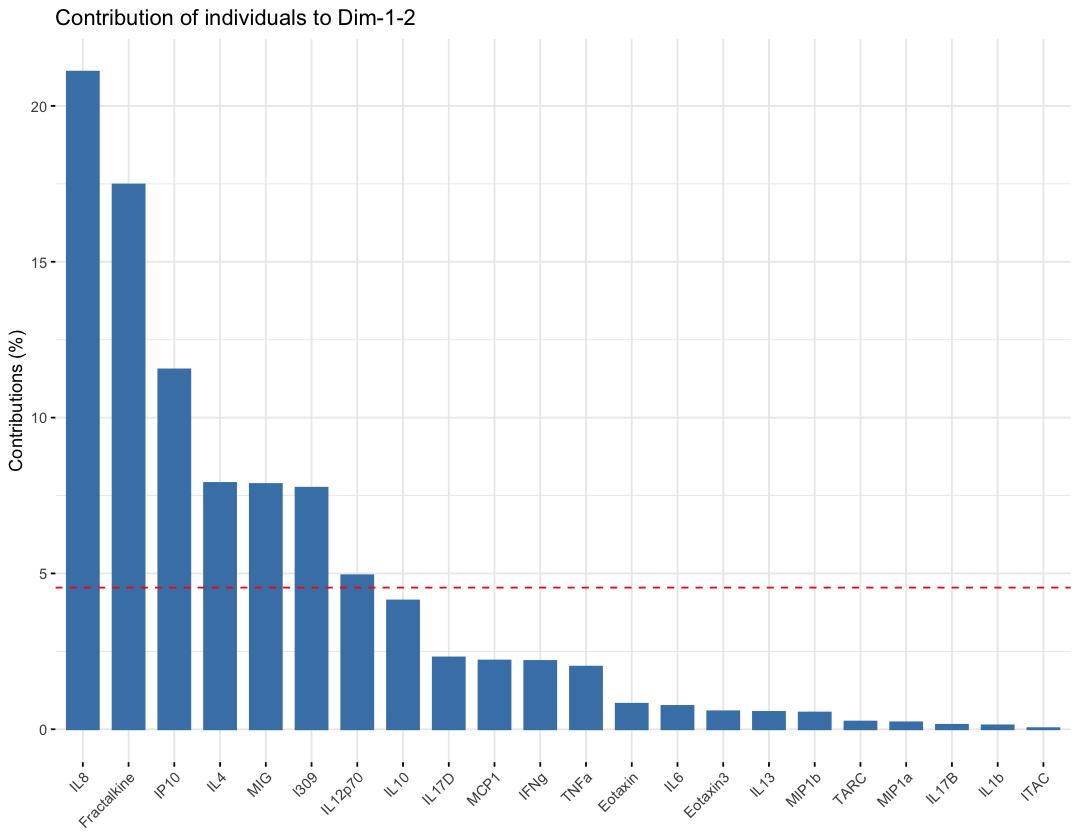

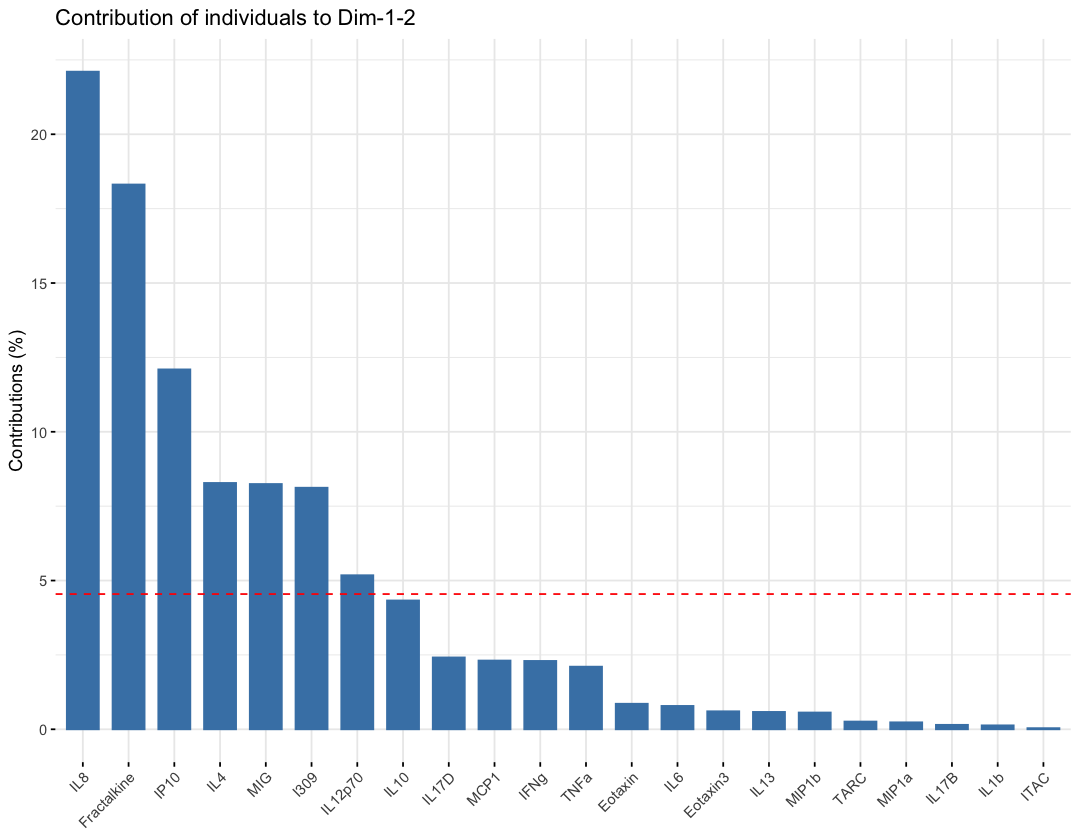

In [49]:
options(repr.plot.width=9, repr.plot.height=7) #changing size

# add words
fviz_contrib(pca_cytokine, choice = "ind", axes = 1:2) 
fviz_contrib(res.pca, choice = "ind", axes = 1:2) 

## Concluding Remarks
WORDS

## Additional Resources
+ [*K*-Means Cluster Analysis](https://uc-r.github.io/kmeans_clustering#silo)
+ [*K*-Means Clustering in R](https://www.datanovia.com/en/lessons/k-means-clustering-in-r-algorith-and-practical-examples/)
+ [Hierarchical Clustering in R](https://uc-r.github.io/hc_clustering)

### Test Your Knowledge
Using the same dataset, answer the questions below. 
1. Determine the optimal number of *k*-means clusters of cytokines derived from the nasal epithelieum lining fluid of **e-cigarette users**. 
2. How do those clusters compare to the ones that were derived at baseline?
3. What do those clusters look like visualized? REWORD